## 1. Importing Libraries
- **numpy**: Deals with multidimensional matrices
- **cv2**: Loads image files from source
- **random**: Randomizes input 
- **matplotlib**: Creates interactive visualizations
- **sklearn**: Provides useful algorithms for machine learning

In [ ]:
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## 2. Loading Dataset
- Data are loaded through a nested loop using **imread** function in **cv2** library. The outer loop changes the folder (class) of the dataset and the inner loop changes the samples in the same folder (class).
- The function gets the path of the dataset to be loaded and returns a (400 x 10305) data matrix.
- Each row represents a data sample and each column represents a feature except for the last column which represents the **subject ID**.

In [ ]:
def load_dataset(path):
  D = []
  for i in range (1, 41):
    for j in range (1, 11):
      img = cv2.imread(path +"s" + str(i) + "/" + str(j) + ".pgm", 0)
      img = np.array(img)
      vec = img.ravel()
      vec = np.append(vec, [i])
      D = np.append(D, vec)
  D = D.reshape((400, 10305))
  return D

## 3. Splitting Dataset
Two functions provide two different approaches of splitting the dataset:

1.   **70 to 30 approach:** Creates one randomized array of ten numbers (0 to 9), splits it into two subarrays, one has 7 elements and the other has 3. The two arrays represent the indices of samples in each folder, the 7-elements array represent the training samples and the 3-elements array represents the test samples.
2.   **50 to 50 approach:** Creates two arrays (in range of 0 to 9), each of 5 elements. One array contains even numbers and the other contains odd ones. The two arrays represent the indices of samples in each folder, the even one represents the training samples and the odd array represents the test samples.

The functions get the data matrix and returns:
- Training sample matrix
- Test sample matrix
- Training sample subject IDs vector
- Test sample subject IDs vector




In [ ]:
def split_dataset_70_30(D):
  numberList = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  random.shuffle(numberList)
  trainIndices = numberList[:7]
  testIndices = numberList[7:]
  D_Train = D_Test = []
  for i in range(40):
    for j in trainIndices:
      D_Train = np.append(D_Train, D[(i*10) + j, :])
    for j in testIndices:
      D_Test = np.append(D_Test, D[(i*10) + j, :])
  D_Train = D_Train.reshape(280, 10305)
  D_Test = D_Test.reshape(120, 10305)
  X_train = D_Train[:, :10304]
  Y_train = D_Train[:, 10304]
  X_test = D_Test[:, :10304]
  Y_test = D_Test[:, 10304]
  return X_train,X_test,Y_train,Y_test

In [ ]:
def split_dataset_50_50(D):
  trainIndices = [0, 2, 4, 6, 8]
  testIndices = [1, 3, 5, 7, 9]
  D_Train = D_Test = []
  for i in range(40):
    for j in trainIndices:
      D_Train = np.append(D_Train, D[(i*10) + j, :])
    for j in testIndices:
      D_Test = np.append(D_Test, D[(i*10) + j, :])
  D_Train = D_Train.reshape(200, 10305)
  D_Test = D_Test.reshape(200, 10305)
  X_train = D_Train[:, :10304]
  Y_train = D_Train[:, 10304]
  X_test = D_Test[:, :10304]
  Y_test = D_Test[:, 10304]
  return X_train,X_test,Y_train,Y_test

## 4. Classification using PCA:
The function gets the wanted explained variance and returns an object of type PCA using **sklearn** library.

In [ ]:
def generate_pca(explained_variance):
  pca = PCA(n_components = explained_variance/100, 
            svd_solver = 'full', copy = True)
  return pca

## 5. Tuning Classifier using K-NN:
The function gets the number of neighbors and returns an object of type KNN Classifier using **sklearn** library.

In [ ]:
def generate_knn(K):
  KNN_classifier = KNeighborsClassifier(n_neighbors = K)
  return KNN_classifier

## 6. Creating a model:
A model gets:
- Matrix of Taining set.
- Vector of Training set IDs.
- Matrix of Test set.
- Vector of Test set IDs.
- Explained Variance for PCA.
- Number of neighbors for K-NN.

The model generates a PCA funciton, with a certain explained variance, and a K-NN function, with a certain number of neighbors, then fits the training set into the PCA model and produces a reduced matrix of training set. The test set matrix is reduced to the same number of features as the training set.

The reduced matrix of training set is entered in the K-NN function along with the IDs of the original training to fit the results.

Finally, predicitons are genereated out of the reduced matrix of test set.

The model function returns:
- K-NN object
- Vector of predictions of the trainig set
- Number of components

In [ ]:
def model(X_train, Y_train, X_test, n_neighbors, explained_variance):
  pca = generate_pca(explained_variance)
  pca.fit(X_train)
  X_train_reduced = pca.transform(X_train)
  X_test_reduced = pca.transform(X_test)

  knn = generate_knn(n_neighbors)
  knn.fit(X_train_reduced, Y_train)
  predictions = knn.predict(X_test_reduced)
  
  return knn, predictions, len(X_train_reduced[1, :-1])

## 7. Testing accuracy:
Testing accuracy of the predictions given the real IDs vector of the test samples.

The accuracy is calculated by dividing the number of true predictions by the total number of predictions.

The function gets thes IDs of the test matrix and the prediction vector and returns a float number (accuracy) between 0 and 1.

In [ ]:
def test_accuracy(Y_test, predictions):
  loss = Y_test == predictions
  count = 0
  for i in loss:
    if i == True:
      count += 1
  return count/len(loss)  

#**Loading Dataset through path**:
Loading dataset using path on drive.

In [ ]:
path = "/content/drive/My Drive/Pattern_Project/dataset_faces/"
dataset = load_dataset(path)

#**Testing the 70% to 30% approach**:
Testing the 70% to 30% approach with different number of neighbors (1, 3, 5, and 7) and different explained variances (0.8, 0.85, 0.9, and 0.95) and printing accuracy for every option to find the highest accuracy value.

In [ ]:
X_train, X_test, Y_train, Y_test = split_dataset_70_30(dataset)
accuracyArray = np.zeros((4, 4))
components = np.zeros(4)
i = 0
for k in range (1, 8, 2):
  j = 0
  for alpha in range (80, 100, 5):
    classifier, predictions, components[j] = model(X_train, Y_train, X_test, k, alpha)
    accuracy = test_accuracy(Y_test, predictions)
    accuracyArray[i][j] += accuracy
    print("Accuracy (at 70-30 split) with k = " + str(k) + ", alpha = " + str(alpha) + " = " + str(accuracy * 100) + "%")
    j += 1
  i += 1

Accuracy (at 70-30 split) with k = 1, alpha = 80 = 96.66666666666667%
Accuracy (at 70-30 split) with k = 1, alpha = 85 = 97.5%
Accuracy (at 70-30 split) with k = 1, alpha = 90 = 97.5%
Accuracy (at 70-30 split) with k = 1, alpha = 95 = 97.5%
Accuracy (at 70-30 split) with k = 3, alpha = 80 = 90.83333333333333%
Accuracy (at 70-30 split) with k = 3, alpha = 85 = 91.66666666666666%
Accuracy (at 70-30 split) with k = 3, alpha = 90 = 90.83333333333333%
Accuracy (at 70-30 split) with k = 3, alpha = 95 = 91.66666666666666%
Accuracy (at 70-30 split) with k = 5, alpha = 80 = 89.16666666666667%
Accuracy (at 70-30 split) with k = 5, alpha = 85 = 89.16666666666667%
Accuracy (at 70-30 split) with k = 5, alpha = 90 = 89.16666666666667%
Accuracy (at 70-30 split) with k = 5, alpha = 95 = 87.5%
Accuracy (at 70-30 split) with k = 7, alpha = 80 = 83.33333333333334%
Accuracy (at 70-30 split) with k = 7, alpha = 85 = 83.33333333333334%
Accuracy (at 70-30 split) with k = 7, alpha = 90 = 82.5%
Accuracy (at 70

#**Testing the 50% to 50% approach**:
Testing the 50% to 50% approach with different number of neighbors (1, 3, 5, and 7) and different explained variances (0.8, 0.85, 0.9, and 0.95) and printing accuracy for every option to find the highest accuracy value.

In [ ]:
X_train, X_test, Y_train, Y_test = split_dataset_50_50(dataset)
accuracyArray = np.zeros((4, 4))
components = np.zeros(4)
i = 0
for k in range (1, 8, 2):
  j = 0
  for alpha in range (80, 100, 5):
    classifier, predictions, components[j] = model(X_train, Y_train, X_test, k, alpha)
    accuracy = test_accuracy(Y_test, predictions)
    accuracyArray[i][j] += accuracy
    print("Accuracy (at 50-50 split) with k = " + str(k) + ", alpha = " + str(alpha) + " = " + str(accuracy * 100) + "%")
    j += 1
  i += 1

Accuracy (at 50-50 split) with k = 1, alpha = 80 = 95.0%
Accuracy (at 50-50 split) with k = 1, alpha = 85 = 95.0%
Accuracy (at 50-50 split) with k = 1, alpha = 90 = 94.0%
Accuracy (at 50-50 split) with k = 1, alpha = 95 = 94.0%
Accuracy (at 50-50 split) with k = 3, alpha = 80 = 89.5%
Accuracy (at 50-50 split) with k = 3, alpha = 85 = 89.5%
Accuracy (at 50-50 split) with k = 3, alpha = 90 = 89.0%
Accuracy (at 50-50 split) with k = 3, alpha = 95 = 89.5%
Accuracy (at 50-50 split) with k = 5, alpha = 80 = 85.0%
Accuracy (at 50-50 split) with k = 5, alpha = 85 = 84.5%
Accuracy (at 50-50 split) with k = 5, alpha = 90 = 83.5%
Accuracy (at 50-50 split) with k = 5, alpha = 95 = 84.5%
Accuracy (at 50-50 split) with k = 7, alpha = 80 = 80.5%
Accuracy (at 50-50 split) with k = 7, alpha = 85 = 77.5%
Accuracy (at 50-50 split) with k = 7, alpha = 90 = 77.0%
Accuracy (at 50-50 split) with k = 7, alpha = 95 = 74.0%


##**Plots**:

#### **1. Accuracy & Number of Neighbors:**
- Number of neighbors = {1, 3, 5, 7}
- Accuracy %


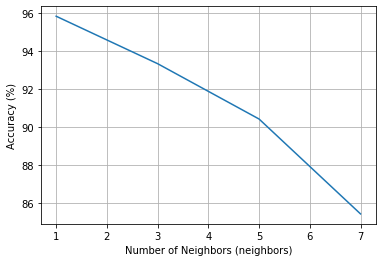

In [ ]:
plt.plot([1, 3, 5, 7], np.mean(accuracyArray * 100, axis = 1))

plt.xlabel('Number of Neighbors (neighbors)')
plt.ylabel('Accuracy (%)')
plt.grid()

#### **2. Accuracy & Explained Variance:**
- Explained Variance = {0.8, 0.85, 0.9, 0.95}
- Accuracy %


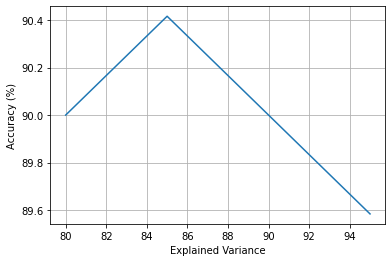

In [ ]:
plt.plot([80, 85, 90, 95], np.mean(accuracyArray * 100, axis = 0))

plt.xlabel('Explained Variance')
plt.ylabel('Accuracy (%)')
plt.grid()

#### **3. Number of Components & Explained Variance:**
- Explained Variance = {0.8, 0.85, 0.9, 0.95}
- Number of Components (Features)


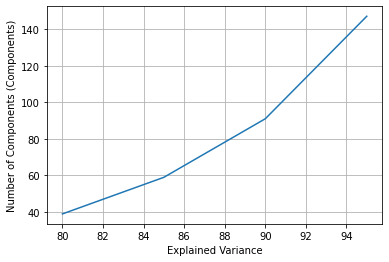

In [ ]:
plt.plot([80, 85, 90, 95], components)

plt.xlabel('Explained Variance')
plt.ylabel('Number of Components (Components)')
plt.grid()

#### **4. Accuracy & Number of Components:**
- Number of Components (Features)
- Accuracy %


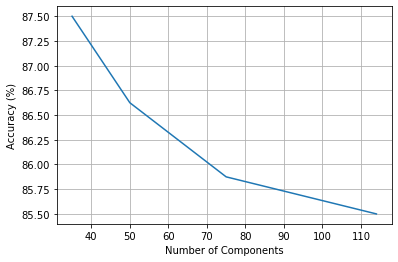

In [ ]:
plt.plot(components, accuracyArray.mean(axis=0) * 100)

plt.xlabel('Number of Components')
plt.ylabel('Accuracy (%)')
plt.grid()

##**Extra**:

#### **Testing Prediction**:
- Testing Predictions one by one given explained variance of PCA and number of neighbors of K-NN.


In [ ]:
def getPredMyTest(i, j, explained_variance, number_of_neighbors):
  img = cv2.imread(path +"s" + str(i) + "/" + str(j) + ".pgm", 0)
  img = np.array(img)
  vec = img.ravel()
  
  pca = generate_pca(explained_variance)
  knn = generate_knn(number_of_neighbors)
  pca.fit(X_train)
  X_train_reduced = pca.transform(X_train)
  knn.fit(X_train_reduced, Y_train)
  myTest = pca.transform(vec.reshape(1, -1))
  myPrediction = knn.predict(myTest)[0]
  
  return myPrediction

In [ ]:
myClass = 31
myPic = 4
a = 95
k = 1
myPrediction = getPredMyTest(myClass, myPic, a, k)
print("My prediction for (" + str(myClass) + ") at 'a' = (" + 
      str(a) + "%) and 'k' = (" + str(k) + ") is:     " + str(myPrediction))

My prediction for (31) at 'a' = (95%) and 'k' = (1) is:     31.0
